In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import \
     (LinearRegression,
      LogisticRegression,
      Lasso)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from sklearn.model_selection import \
     (train_test_split,
      GridSearchCV)

# New import
import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import (MeanAbsoluteError,
                          R2Score)
from torchinfo import summary
from torchvision.io import read_image
from torchvision import transforms
from pytorch_lightning import Trainer
from pytorch_lightning.loggers import CSVLogger
from pytorch_accelerated.trainer import Trainer as Trainer_accelerated
from lightning_lite.utilities.seed import seed_everything
seed_everything(0, workers=True)

from torchvision.datasets import MNIST, CIFAR100, ImageFolder
from torchvision.models import (resnet50,
                                ResNet50_Weights)
from torchvision.transforms import (Compose,
                                    Resize,
                                    Normalize,
                                    CenterCrop,
                                    ToTensor)
from tqdm.notebook import tqdm
from ISLP.torch import (SimpleDataModule,
                        SimpleModule,
                        ErrorTracker,
                        rec_num_workers)
from ISLP.torch.imdb import (load_lookup,
                             load_tensor,
                             load_sparse,
                             load_sequential)
from glob import glob
from PIL import Image
import json

import os

2023-11-12 08:46:55.624120: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-12 08:46:56.969800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 0


# Lab

## Single Layer Network on Hitters Data

In [2]:
Hitters = load_data('Hitters').dropna()
n = Hitters.shape[0]
model = MS(Hitters.columns.drop('Salary'), intercept=False)
X = model.fit_transform(Hitters).to_numpy()
Y = Hitters['Salary'].to_numpy()
(X_train,
 X_test,
 Y_train,
 Y_test) = train_test_split(X,
                            Y,
                            test_size=1/3,
                            random_state=15)

In [3]:
hit_lm = LinearRegression().fit(X_train, Y_train)
Yhat_test = hit_lm.predict(X_test)
np.abs(Yhat_test - Y_test).mean()

268.4318316759006

Here lam_max is the smallest value of λ with an all-
zero solution. This value equals the largest absolute inner-product between
any predictor and the (centered) response.

In [4]:
scaler = StandardScaler(with_mean=True, with_std=True)
lasso = Lasso(warm_start=True, max_iter=30000)
standard_lasso = Pipeline(steps=[('scaler', scaler),
                                 ('lasso', lasso)])
X_s = scaler.fit_transform(X_train)
n = X_s.shape[0]
lam_max = np.fabs(X_s.T.dot(Y_train - Y_train.mean())).max() / n
param_grid = {'alpha': np.exp(np.linspace(0, np.log(0.01), 100)) * lam_max}
cv = KFold(10,
           shuffle=True,
           random_state=1)
grid = GridSearchCV(lasso,
                    param_grid,
                    cv=cv,
                    scoring='neg_mean_absolute_error')
grid.fit(X_train, Y_train)
trained_lasso = grid.best_estimator_
Yhat_test = trained_lasso.predict(X_test)
np.fabs(Yhat_test - Y_test).mean()

260.62310560666066

### Specifying a Network: Classes and Inheritance

In [5]:
class HittersModel(nn.Module):

    def __init__(self, input_size):
        super(HittersModel, self).__init__()
        self.flatten = nn.Flatten()
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(50, 1))

    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [6]:
hit_model = HittersModel(X.shape[1])
summary(hit_model,
        input_size=X_train.shape,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [175, 19]                 [175]                     --
├─Flatten: 1-1                           [175, 19]                 [175, 19]                 --
├─Sequential: 1-2                        [175, 19]                 [175, 1]                  --
│    └─Linear: 2-1                       [175, 19]                 [175, 50]                 1,000
│    └─ReLU: 2-2                         [175, 50]                 [175, 50]                 --
│    └─Dropout: 2-3                      [175, 50]                 [175, 50]                 --
│    └─Linear: 2-4                       [175, 50]                 [175, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.18
Input size (MB): 0.01
Forward/backward pass size (MB): 0.07
Params size (MB): 0.00
Estimated Total Size (MB): 0.09

In [7]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
hit_train = TensorDataset(X_train_t, Y_train_t)

X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
hit_test = TensorDataset(X_test_t, Y_test_t)

In [24]:
max_num_workers = rec_num_workers()

In [9]:
hit_dm = SimpleDataModule(hit_train,
                          hit_test,
                          batch_size=32,
                          num_workers=min(4, max_num_workers),
                          validation=hit_test)
hit_module = SimpleModule.regression(hit_model,
                                     metrics = {'mae':MeanAbsoluteError()})

In [10]:
hit_logger = CSVLogger('logs', name='hitters')
hit_trainer = Trainer(deterministic=True,
                      max_epochs=50,
                      log_every_n_steps=5,
                      logger=hit_logger,
                      callbacks=[ErrorTracker()])
hit_trainer.fit(hit_module, datamodule=hit_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [11]:
hit_trainer.test(hit_module, datamodule=hit_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss               85880.09375
        test_mae              205.64111328125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 85880.09375, 'test_mae': 205.64111328125}]

In [12]:
hit_results = pd.read_csv(hit_logger.experiment.metrics_file_path)

In [18]:
# plot of MAE as a function of the number of epochs
def summary_plot(results,
                 ax,
                 col='loss',
                 valid_legend='Validation',
                 training_legend='Training',
                 ylabel='Loss',
                 fontsize=20):
    for (column,
         color,
         label) in zip([f'train_{col}_epoch',
                        f'valid_{col}'],
                       ['black',
                        'red'],
                       [training_legend,
                        valid_legend]):
        results.plot(x='epoch',
                     y=column,
                     label=label,
                     marker='o',
                     color=color,
                     ax=ax)
    ax.set_xlabel('Epoch')
    ax.set_ylabel(ylabel)
    return ax

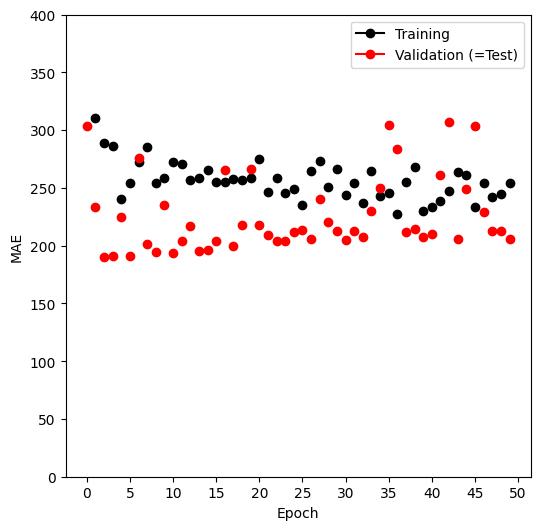

In [14]:
fig = plt.figure(figsize=(6, 6)); ax = fig.add_subplot()
ax = summary_plot(hit_results,
                  ax,
                  col='mae',
                  ylabel='MAE',
                  valid_legend='Validation (=Test)')
ax.set_ylim([0, 400])
ticks = ax.set_xticks(np.linspace(0, 50, 11).astype(int))

In [15]:
hit_model.eval()
preds = hit_module(X_test_t)
torch.abs(Y_test_t - preds).mean()

tensor(205.6411, grad_fn=<MeanBackward0>)

In [16]:
del(Hitters,
    hit_model, hit_dm,
    hit_logger,
    hit_test, hit_train,
    X, Y,
    X_test, X_train,
    Y_test, Y_train,
    X_test_t, Y_test_t,
    hit_trainer, hit_module)

## Multilayer Network on the MNIST Digit Data

In [17]:
(mnist_train,
 mnist_test) = [MNIST(root='data',
                      train=train,
                      download=True,
                      transform=ToTensor())
                for train in [True, False]]

In [18]:
mnist_train

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [19]:
mnist_dm = SimpleDataModule(mnist_train,
                            mnist_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=256)

In [20]:
for idx, (X_, Y_) in enumerate(mnist_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


In [21]:
class MNISTModel(nn.Module):
    def __init__(self):
        super(MNISTModel, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Dropout(0.4))
        self.layer2 = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3))
        self._forward = nn.Sequential(
            self.layer1,
            self.layer2,
            nn.Linear(128, 10))
    def forward(self, x):
        return self._forward(x)

In [22]:
mnist_model = MNISTModel()

In [23]:
mnist_model(X_).size()

torch.Size([256, 10])

In [24]:
summary(mnist_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [36]:
mnist_module = SimpleModule.classification(mnist_model, 10)
mnist_logger = CSVLogger('logs', name='MNIST')

In [41]:
mnist_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=mnist_logger,
                        callbacks=[ErrorTracker()])
mnist_trainer.fit(mnist_module,
                  datamodule=mnist_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/MNIST

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNISTModel       | 235 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


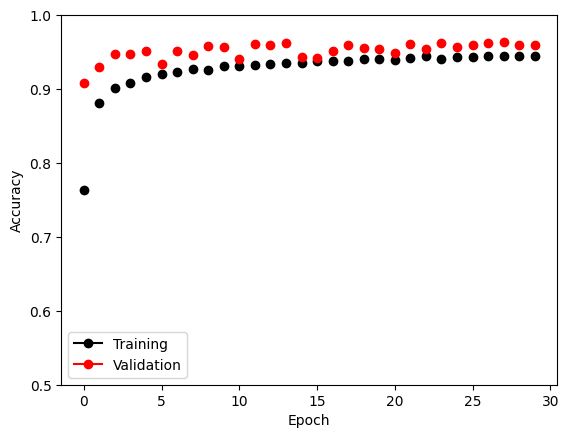

In [42]:
mnist_results = pd.read_csv(mnist_logger.experiment.
                            metrics_file_path)
fig = plt.figure(); ax = fig.add_subplot()
summary_plot(mnist_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_ylim([0.5, 1])
ax.set_ylabel('Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int))

In [43]:
mnist_trainer.test(mnist_module,
                   datamodule=mnist_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9596999883651733
        test_loss           0.1531633734703064
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.1531633734703064, 'test_accuracy': 0.9596999883651733}]

In [46]:
class MNIST_MLR(nn.Module):
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 10))
    def forward(self, x):
        return self.linear(x)

mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model, 10)
mlr_logger = CSVLogger('logs', name='MNIST_MLR')

In [47]:
mlr_trainer = Trainer(deterministic=True,
                      max_epochs=30,
                      callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module, datamodule=mnist_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(
Missing logger folder: /media/alex/SSD_ALEX/statlearning/scripts/lightning_logs

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNIST_MLR        | 7.9 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [48]:
mlr_trainer.test(mlr_module,
                 datamodule=mnist_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9142000079154968
        test_loss           0.3529835343360901
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.3529835343360901, 'test_accuracy': 0.9142000079154968}]

In [49]:
del(mnist_test,
    mnist_train,
    mnist_model,
    mnist_trainer,
    mnist_module,
    mnist_results,
    mlr_model,
    mlr_module,
    mlr_trainer)

## Convolutional Neural Networks

In [25]:
(cifar_train,
 cifar_test) = [CIFAR100(root='data',
                         train=train,
                         download=True)
                for train in [True, False]]

Files already downloaded and verified
Files already downloaded and verified


In [26]:
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in cifar_test.data])
cifar_train = TensorDataset(cifar_train_X,
                            torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X,
                           torch.tensor(cifar_test.targets))

In [34]:
cifar_train_X.shape

torch.Size([50000, 3, 32, 32])

In [27]:
cifar_dm = SimpleDataModule(cifar_train,
                            cifar_test,
                            validation=0.2,
                            num_workers=max_num_workers,
                            batch_size=128)

In [28]:
for idx, (X_, Y_) in enumerate(cifar_dm.train_dataloader()):
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


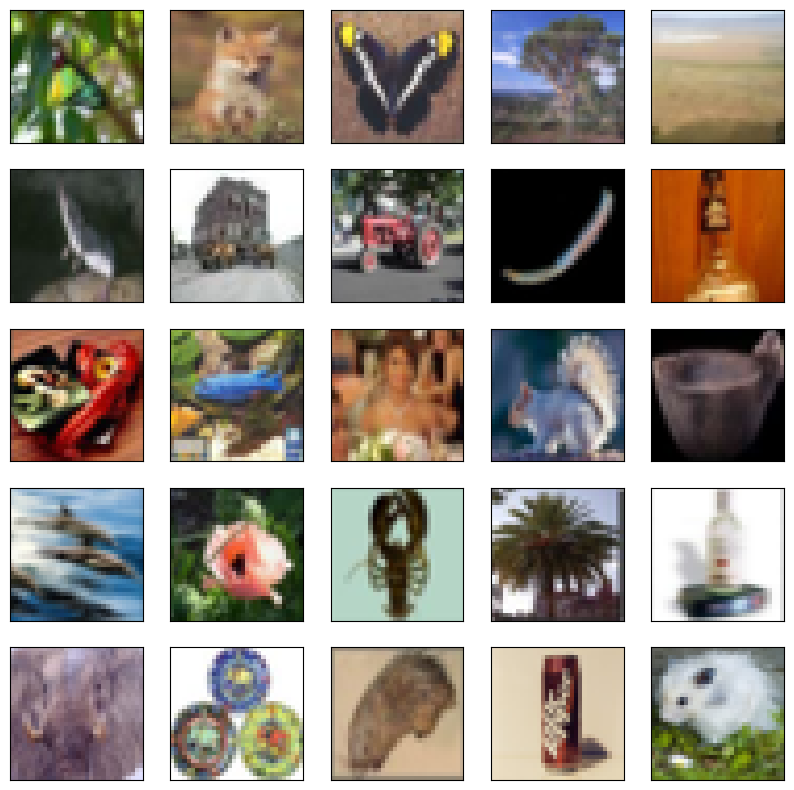

In [29]:
fig = plt.figure(figsize=(10,10))
rng = np.random.default_rng(4)
indices = rng.choice(np.arange(len(cifar_train)), 25,
                     replace=True)
for i in range(25):
    idx = indices[i]
    ax = fig.add_subplot(5, 5, i+1)
    ax.imshow(np.transpose(cifar_train[idx][0],
                           [1, 2, 0]),
                           interpolation=None)
    ax.set_yticks([])
    ax.set_xticks([])

In [30]:
class BuildingBlock(nn.Module):

    def __init__(self,
                 in_channels,
                 out_channels):
        super(BuildingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels,
                              out_channels=out_channels,
                              kernel_size=(3,3),
                              padding='same')
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))

In [31]:
class CIFARModel(nn.Module):
    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3, 32),
                 (32, 64),
                 (64, 128),
                 (128, 256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_)
                                    for in_, out_ in sizes])
        self.output = nn.Sequential(nn.Dropout(0.5),
                                    nn.Linear(2*2*256, 512),
                                    nn.ReLU(),
                                    nn.Linear(512, 100))
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)

In [32]:
cifar_model = CIFARModel()
summary(cifar_model,
        input_data=X_,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

In [140]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)
cifar_module = SimpleModule.classification(cifar_model,
                                           optimizer=cifar_optimizer,
                                           num_classes=100)
cifar_logger = CSVLogger('logs', name='CIFAR100')

In [141]:
cifar_trainer = Trainer(deterministic=True,
                        max_epochs=30,
                        logger=cifar_logger,
                        callbacks=[ErrorTracker()])
cifar_trainer.fit(cifar_module,
                  datamodule=cifar_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | CIFARModel       | 964 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


(0.0, 1.0)

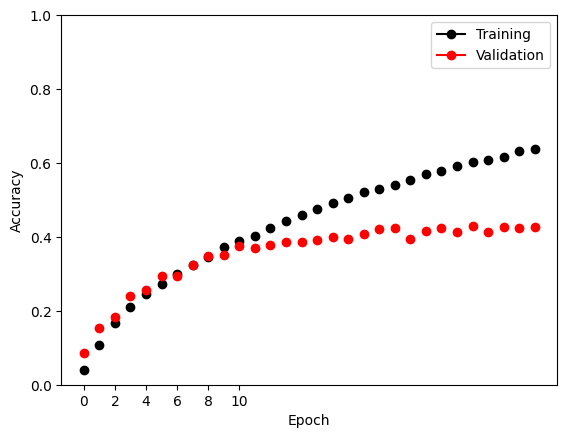

In [142]:
log_path = cifar_logger.experiment.metrics_file_path
cifar_results = pd.read_csv(log_path)
fig = plt.figure(); ax = fig.add_subplot()
summary_plot(cifar_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 10, 6).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0, 1])

In [143]:
cifar_trainer.test(cifar_module,
                   datamodule=cifar_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.42489999532699585
        test_loss           2.4424588680267334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.4424588680267334, 'test_accuracy': 0.42489999532699585}]

### Hardware acceleration

In [147]:
try:
    for name, metric in cifar_module.metrics.items():
        cifar_module.metrics[name] = metric.to('mps')
    cifar_trainer_mps = Trainer(acceleration='mps',
                                deterministic=True,
                                max_epochs=30)
    cifar_trainer_mps.fit(cifar_module,
                          datamodule=cifar_dm)
    cifar_trainer_mps.test(cifar_module,
                           datamodule=cifar_dm)
except Exception as e:
    print(e)

PyTorch is not linked with support for mps devices


## Using Pretrained CNN Models

In [8]:
resize = Resize((232, 232))
crop = CenterCrop(224)
normalize = Normalize([0.485, 0.456, 0.406],
                      [0.229, 0.224, 0.225])
imgfiles = sorted([f for f in glob('../datasets/book_images/*')])
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255)
                    for f in imgfiles])
imgs = normalize(imgs)
imgs.size()

torch.Size([5, 3, 224, 224])

In [9]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model,
        input_data=imgs,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/alex/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████████████████████████████████| 97.8M/97.8M [00:01<00:00, 66.8MB/s]


Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [5, 3, 224, 224]          [5, 1000]                 --
├─Conv2d: 1-1                            [5, 3, 224, 224]          [5, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [5, 64, 112, 112]         [5, 64, 112, 112]         128
├─ReLU: 1-3                              [5, 64, 112, 112]         [5, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [5, 64, 112, 112]         [5, 64, 56, 56]           --
├─Sequential: 1-5                        [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [5, 64, 56, 56]           [5, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [5, 64, 56, 56]           [5, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [5, 64, 56, 56]           [5, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [10]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
img_preds = resnet_model(imgs)

In [31]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:, None]

In [39]:
labs = json.load(open('../datasets/book_images/imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in
                             labs.items()],
                             columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

In [40]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: ../datasets/book_images/Cape_Weaver.jpg
       label      prob
0    jacamar  0.278434
1  bee_eater  0.047995
2     bulbul  0.039502
Image: ../datasets/book_images/Hawk_Fountain.jpg
            label      prob
0  great_grey_owl  0.281774
1            kite  0.042421
2        fountain  0.029358
Image: ../datasets/book_images/Hawk_cropped.jpg
    label      prob
0    kite  0.297028
1     jay  0.125653
2  magpie  0.015670
Image: ../datasets/book_images/Lhasa_Apso.jpg
             label      prob
0            Lhasa  0.150388
1         Shih-Tzu  0.129438
2  Tibetan_terrier  0.103615
Image: ../datasets/book_images/Sleeping_Cat.jpg
       label      prob
0      tabby  0.172463
1  tiger_cat  0.110840
2    doormat  0.089069


## IMDB Document Classification

In [3]:
(imdb_seq_train,
 imdb_seq_test) = load_sequential(root='../datasets/IMDB')
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])
sample_review = padded_sample[padded_sample > 0][:12]
sample_review[:12]

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468], dtype=int32)

In [4]:
lookup = load_lookup(root='../datasets/IMDB')
' '.join(lookup[i] for i in sample_review)

"<START> this film was just brilliant casting location scenery story direction everyone's"

In [5]:
max_num_workers = 10
(imdb_train,
 imdb_test) = load_tensor(root='data/IMDB')
imdb_dm = SimpleDataModule(imdb_train,
                           imdb_test,
                           validation=2000,
                           num_workers=min(6, max_num_workers),
                           batch_size=512)

In [6]:
class IMDBModel(nn.Module):

    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)

    def forward(self, x):
        val = x
        for _map in [self.dense1,
                     self.activation,
                     self.dense2,
                     self.activation,
                     self.output]:
            val = _map(val)
        return torch.flatten(val)

In [7]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])
summary(imdb_model,
        input_size=imdb_test.tensors[0].size(),
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

In [8]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(
                    imdb_model,
                    optimizer=imdb_optimizer)

In [9]:
imdb_logger = CSVLogger('logs', name='IMDB')
imdb_trainer = Trainer(deterministic=True,
                       max_epochs=30,
                       logger=imdb_logger,
                       callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module,
                 datamodule=imdb_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel         | 160 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/pytorch_lightning/trainer/trainer.py:1595: PossibleUserWarning: The number of training batches (45) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [10]:
test_results = imdb_trainer.test(imdb_module, datamodule=imdb_dm)
test_results

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8501600027084351
        test_loss           1.0867705345153809
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0867705345153809, 'test_accuracy': 0.8501600027084351}]

### Comparison to Lasso

In [11]:
((X_train, Y_train),
 (X_valid, Y_valid),
 (X_test, Y_test)) = load_sparse(validation=2000,
                                 random_state=0,
                                 root='data/IMDB')

In [12]:
lam_max = np.abs(X_train.T * (Y_train - Y_train.mean())).max()
lam_val = lam_max * np.exp(np.linspace(np.log(1),
                                       np.log(1e-4), 50))

In [13]:
logit = LogisticRegression(penalty='l1',
                           C=1/lam_max,
                           solver='liblinear',
                           warm_start=True,
                           fit_intercept=True)

In [14]:
coefs = []
intercepts = []

for l in lam_val:
    logit.C = 1/l
    logit.fit(X_train, Y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

In [15]:
coefs = np.squeeze(coefs)
intercepts = np.squeeze(intercepts)

Training
Validation
Test


Text(0, 0.5, 'Accuracy')

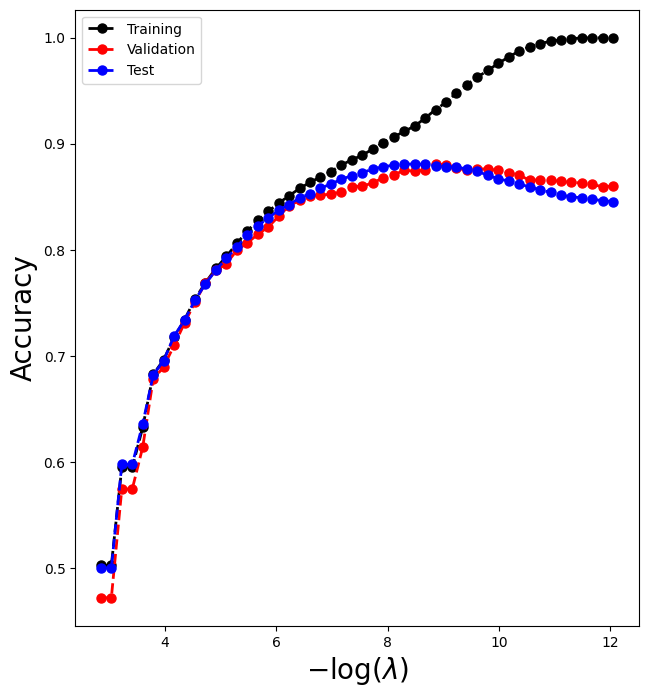

In [16]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(1, 2, 1)
for ((X_, Y_),
     data_,
     color) in zip([(X_train, Y_train),
                    (X_valid, Y_valid),
                    (X_test, Y_test)],
                    ['Training', 'Validation', 'Test'],
                    ['black', 'red', 'blue']):
    print(data_)
    linpred_ = X_ * coefs.T + intercepts[None, :]
    label_ = np.array(linpred_ > 0)
    accuracy_ = np.array([np.mean(Y_ == l) for l in label_.T])
    
    ax.plot(-np.log(lam_val / X_train.shape[0]),
            accuracy_,
            '.--',
            color=color,
            markersize=13,
            linewidth=2,
            label=data_)

ax.legend()
ax.set_xlabel(r'$-\log(\lambda)$', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)

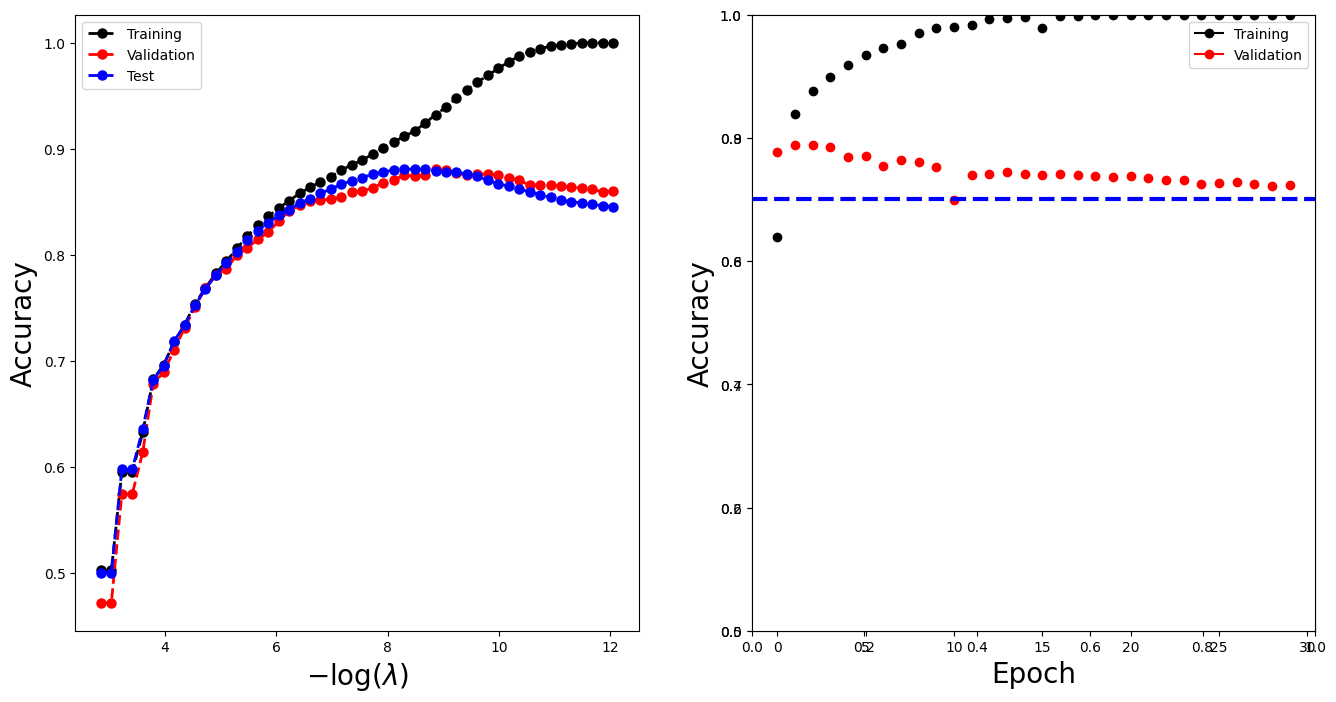

In [19]:
imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
ax = fig.add_subplot(1, 2, 2)
summary_plot(imdb_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 30, 7).astype(int))
ax.set_ylabel('Accuracy', fontsize=20)
ax.set_xlabel('Epoch', fontsize=20)
ax.set_ylim([0.5, 1])
ax.axhline(test_results[0]['test_accuracy'],
           color='blue',
           linestyle='--',
           linewidth=3)
fig

In [20]:
del(imdb_model,
    imdb_trainer,
    imdb_logger,
    imdb_dm,
    imdb_train,
    imdb_test)

## Recurrent Neural Networks

### Sequential Models for Document Classification

In [21]:
imdb_seq_dm = SimpleDataModule(imdb_seq_train,
                               imdb_seq_test,
                               validation=2000,
                               batch_size=300,
                               num_workers=min(6, max_num_workers))

In [22]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, 32)
        self.lstm = nn.LSTM(input_size=32,
                            hidden_size=32,
                            batch_first=True)
        self.dense = nn.Linear(32, 1)

    def forward(self, x):
        val, (h_n, c_n) = self.lstm(self.embedding(x))
        return torch.flatten(self.dense(val[:, -1]))

In [23]:
lstm_model = LSTMModel(X_test.shape[-1])
summary(lstm_model,
        input_data=imdb_seq_train.tensors[0][:10],
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

In [24]:
lstm_module = SimpleModule.binary_classification(lstm_model)
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')

In [26]:
lastm_trainer = Trainer(deterministic=True,
                        max_epochs=20,
                        logger=lstm_logger,
                        callbacks=[ErrorTracker()])
lastm_trainer.fit(lstm_module,
                 datamodule=imdb_seq_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/IMDB_LSTM

  | Name  | Type              | Params
--------------------------------------------
0 | model | LSTMModel         | 328 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


In [28]:
lastm_trainer.test(lstm_module, datamodule=imdb_seq_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.860040009021759
        test_loss           0.7517442107200623
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7517442107200623, 'test_accuracy': 0.860040009021759}]

(0.5, 1.0)

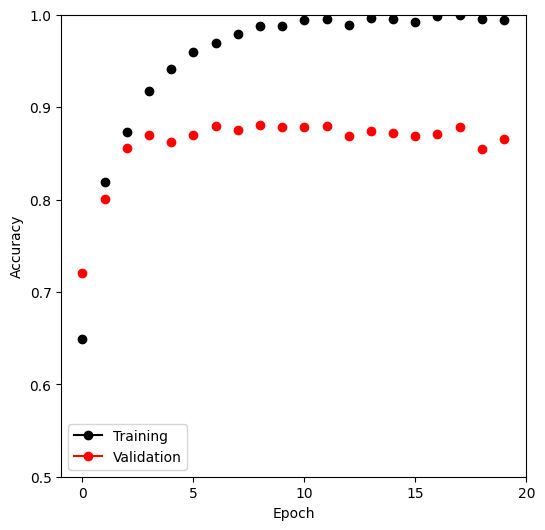

In [29]:
lstm_results = pd.read_csv(lstm_logger.experiment.metrics_file_path)
fig = plt.figure(figsize=(6, 6)); ax = fig.add_subplot()
summary_plot(lstm_results,
             ax,
             col='accuracy',
             ylabel='Accuracy')
ax.set_xticks(np.linspace(0, 20, 5).astype(int))
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1])

In [32]:
del(lstm_model,
    lastm_trainer,
    lstm_logger,
    imdb_seq_dm,
    imdb_seq_train,
    imdb_seq_test)

### Time Series Prediction

In [406]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
                    with_mean=True,
                    with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)

In [407]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), '{0}_{1}'.format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [408]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [409]:
M = LinearRegression()
M.fit(X[train], Y[train])
M.score(X[~train], Y[~train])

0.4128912938562521

In [410]:
X_day = pd.merge(X,
                 pd.get_dummies(NYSE['day_of_week']),
                 on='date')

In [411]:
M.fit(X_day[train], Y[train])
M.score(X_day[~train], Y[~train])

0.4595563133053273

In [63]:
ordered_cols = []
for lag in range (5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col , lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [64]:
X_rnn = X.to_numpy().reshape((-1, 5, 3))
X_rnn.shape

(6046, 5, 3)

In [77]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3,
                          12,
                          batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:, -1]))
        return torch.flatten(val)
nyse_model = NYSEModel()

In [78]:
datasets = []
for mask in [train, ~train]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    Y_t = torch.tensor(Y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, Y_t))
nyse_train, nyse_test = datasets

In [79]:
summary(nyse_model,
        input_data=X_rnn_t,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

In [82]:
nyse_dm = SimpleDataModule(nyse_train,
                           nyse_test,
                           num_workers=min(4, max_num_workers),
                           validation=nyse_test,
                           batch_size=64)

In [83]:
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break

torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


In [84]:
nyse_optimizer = RMSprop(nyse_model.parameters(),
                         lr=0.001)
nyse_module = SimpleModule.regression(nyse_model,
                                      optimizer=nyse_optimizer,
                                      metrics={'r2':R2Score()})

In [85]:
nyse_trainer = Trainer(deterministic=True,
                       max_epochs=200,
                       callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type      | Params
------------------------------------
0 | model | NYSEModel | 217   
1 | loss  | MSELoss   | 0     
------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.614131510257721
         test_r2            0.41715919971466064
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.614131510257721, 'test_r2': 0.41715919971466064}]

In [86]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
                np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

In [87]:
day_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=min(4, max_num_workers),
                          validation=day_test,
                          batch_size=64)

In [89]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),
                                      nn.Linear(20, 32),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(32, 1))
    def forward(self, x):
        return torch.flatten(self._forward(x))

In [91]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),
                       lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                    optimizer=nl_optimizer,
                                    metrics={'r2':R2Score()})


In [92]:
nl_trainer = Trainer(deterministic=True,
                     max_epochs=20,
                     callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | NonLinearARModel | 705   
1 | loss  | MSELoss          | 0     
-------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5623886585235596
         test_r2            0.4662657380104065
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5623886585235596, 'test_r2': 0.4662657380104065}]

# Exercises

## Conceptual

1. Consider a neural network with two hidden layers: p = 4 input units, 2 units in the first hidden layer, 3 units in the second hidden layer, and a single output.

   (a) Draw a picture of the network, similar to Figures 10.1 or 10.4.

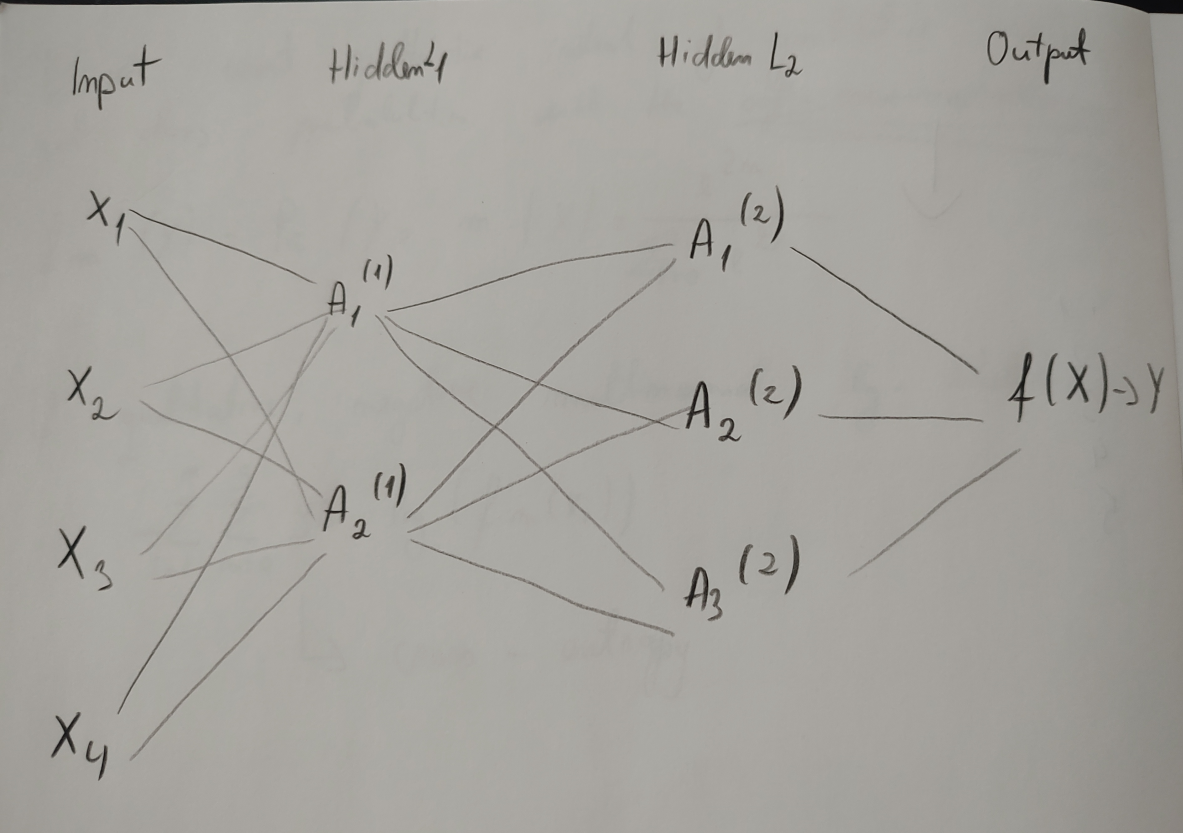

(b) Write out an expression for $f(x)$, asumming ReLU activation functions. Be as explicit as you can!

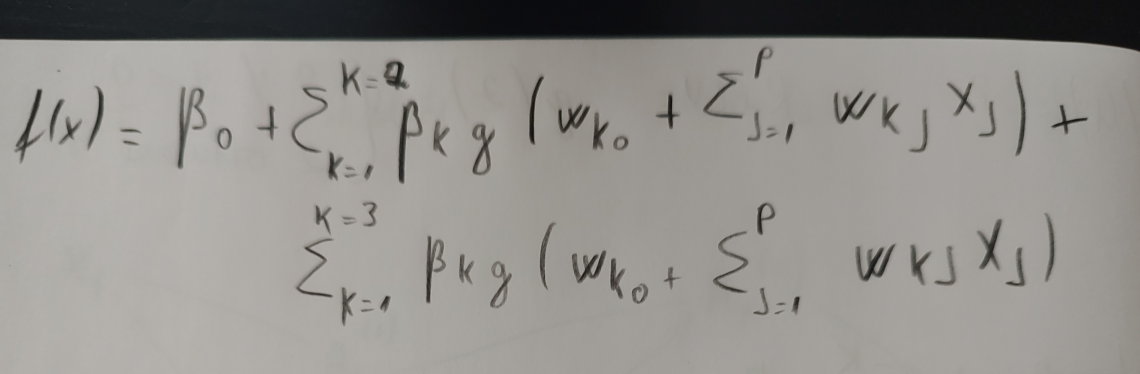

(c) Now plug in some values for the coefficients and write out the value of f(X).

In [375]:
X = np.random.rand(4, 100)
W1 = np.random.rand(2, 4)

W1.dot(X)

array([[0.22572417, 0.34575496, 1.55240184, 1.40926843, 1.20493286,
        1.47450387, 1.25223592, 1.06951932, 1.14011147, 0.44304607,
        0.99368747, 0.64572064, 1.29364221, 0.53458248, 0.75801486,
        1.43145866, 0.52580814, 0.46964681, 0.6062735 , 0.31962263,
        0.65427798, 0.65690835, 0.92947956, 0.74106707, 1.11940709,
        0.49307887, 0.79597792, 1.04131037, 0.7830559 , 1.28166587,
        0.57407207, 1.42045362, 0.26926379, 0.76407114, 1.12656737,
        0.47655268, 1.19645634, 0.78118   , 0.83357141, 1.06502906,
        0.51616495, 0.53170087, 1.25892943, 1.50276212, 0.98641679,
        0.89768988, 1.13926231, 0.83824935, 0.98059185, 0.88480347,
        0.83660426, 0.78265014, 0.73939148, 1.45281503, 0.55821648,
        0.49701534, 0.9950052 , 0.48137247, 0.81957874, 0.50589463,
        1.09332354, 1.14716279, 0.77678823, 0.93429875, 0.44153848,
        1.28973306, 0.35844518, 1.04920457, 0.33048533, 0.58230599,
        0.62669455, 1.0514363 , 1.17649729, 0.71

In [3]:
np.random.seed(5)
def get_params():
    X = np.random.rand(100, 4)
    intercept = 1
    L1 = {}
    L2 = {}
    L1['activation_intercepts'] = np.random.rand(2, 1)
    L1['activation_weights'] = np.random.rand(2, 4)
    L2['neuron_weights'] = np.random.rand(3, 1)
    L2['activation_intercepts'] = np.random.rand(3, 1)
    L2['activation_weights'] = np.random.rand(2, 1)
    return X, intercept, L1, L2
    

def ReLU(z):
    return np.maximum(0, z)

def compute_activations(X, activation_intercepts, layer_activation_weights):
    return np.stack([compute_activation(X, activation_intercept, activation_weights)
                     for activation_intercept, activation_weights in zip(activation_intercepts, layer_activation_weights)]).transpose()

def compute_activation(X, activation_intercept, activation_weights):
    return ReLU(activation_intercept + np.sum([activation_weights[i] * X[:, i]
                                               for i in range(len(activation_weights))], 0))

def compute_output_layer(intercept, activations, neuron_weights):
    return intercept + np.sum([activations[:, i] * neuron_weights[i]
                               for i in range(activations.shape[1])], 0)

def compute_function():
    X, intercept, L1, L2 = get_params()
    X = X_try
    L1['activations'] = compute_activations(X, L1['activation_intercepts'], L1['activation_weights'])
    L2['activations'] = compute_activations(L1['activations'], L2['activation_intercepts'], L2['activation_weights'])
    output_layer = compute_output_layer(intercept, L2['activations'], L2['neuron_weights'])
    return output_layer

compute_function()

array([3.41639718, 3.21937571, 3.54310993, 3.12586376, 3.40697692,
       3.55034762, 2.87233806, 2.996381  , 2.86530915, 3.64736258,
       3.22742908, 3.12931341, 3.09165405, 2.94483494, 3.08448284,
       2.93291589, 3.21410109, 3.46301809, 3.6102445 , 2.7221103 ,
       2.75805237, 3.08994303, 3.34325211, 2.99215811, 3.18284592,
       3.33878439, 3.20589806, 3.31273078, 3.39398935, 3.69452433,
       3.63707767, 2.85799033, 3.22968918, 2.98673709, 3.42330443,
       3.25973827, 3.16328058, 3.32460653, 2.85795428, 3.27421954,
       3.43576418, 3.22664161, 3.10210671, 3.00457424, 3.50122901,
       3.16884752, 3.47333897, 3.09751418, 3.4921686 , 2.61306594,
       3.12171094, 2.88492349, 3.78487496, 2.78871119, 3.13728652,
       3.30659126, 3.44461564, 3.31717059, 2.71672321, 2.96256027,
       3.12885547, 3.26201531, 2.95537729, 3.72670722, 3.5984892 ,
       2.52537117, 3.2702907 , 3.37843647, 3.21108237, 3.66472186,
       3.3696918 , 3.29115104, 3.1586056 , 3.15203445, 3.60507

In [18]:
np.random.seed(5)
def init_params():
    X = np.random.rand(4, 100)
    b0 = np.random.rand(1, 1)
    b1 = np.random.rand(2, 1)
    W1 = np.random.rand(2, 4)
    b2 = np.random.rand(3, 1)
    W2 = np.random.rand(3, 2)
    bW = np.random.rand(1, 3)
    return b0, X, b1, W1, bW, b2, W2

def ReLU(z):
    return np.maximum(0, z)

def forward_prop(W1, b1, W2, b2, X):
    Z1 = W1.dot(X) + b1
    A1 = ReLU(Z1)
    Z2 = W2.dot(A1) + b2
    A2 = ReLU(Z2)
    return A2

def output_layer(b0, bW, A2):
    return b0 + bW.dot(A2)

def compute():
    b0, X, b1, W1, bW, b2, W2 = init_params()
    A2 = forward_prop(W1, b1, W2, b2, X)
    return output_layer(b0, bW, A2)

(d) How many parameters are there?

In [14]:
elements = init_params()
parameters = 0
for element in elements:
    parameters += element.shape[0]
parameters

16

2. Consider the softmax function in 10.13 for modeling multinomial probabilities.

   (a) In 10.13, show that if we add a constant $c$ to each of the $z_l$, then the probability is unchanged.

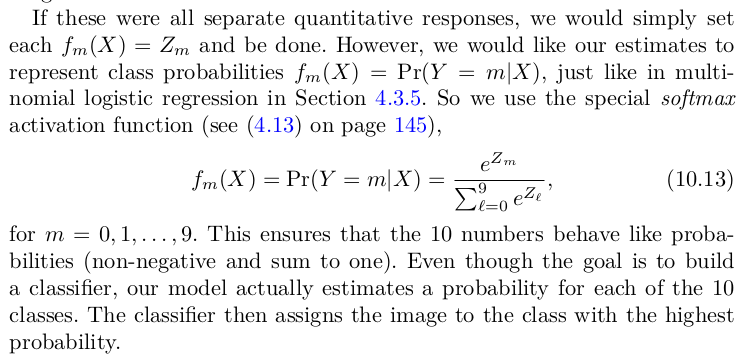

In [107]:
np.random.seed(5)
Z_class1 = compute()
Z_class2 = Z_class1.copy()
Z_class2 = Z_class2 - (np.random.rand(Z_class2.shape[0]) + 1)

class1_prob = np.exp(Z_class1) / (np.exp(Z_class1) + np.exp(Z_class2))
class2_prob = np.exp(Z_class2) / (np.exp(Z_class1) + np.exp(Z_class2))

Z_class1 += 5
Z_class2 += 5
class1_prob_with_constant = np.exp(Z_class1) / (np.exp(Z_class1) + np.exp(Z_class2))
class2_prob_with_constant = np.exp(Z_class2) / (np.exp(Z_class1) + np.exp(Z_class2))

# class1_prob == class1_prob_with_constant, class2_prob == class2_prob_with_constant

In [119]:
class1_prob[0][:10], class1_prob_with_constant[0][:10]

(array([0.7668132, 0.7668132, 0.7668132, 0.7668132, 0.7668132, 0.7668132,
        0.7668132, 0.7668132, 0.7668132, 0.7668132]),
 array([0.7668132, 0.7668132, 0.7668132, 0.7668132, 0.7668132, 0.7668132,
        0.7668132, 0.7668132, 0.7668132, 0.7668132]))

(b) In 4.13, show that if we add constants $c_j$, $j = 0, 1, ....,p$, to each of the corresponding coefficients for each of the classes, then the predictors at any new point $x$ are unchanged.

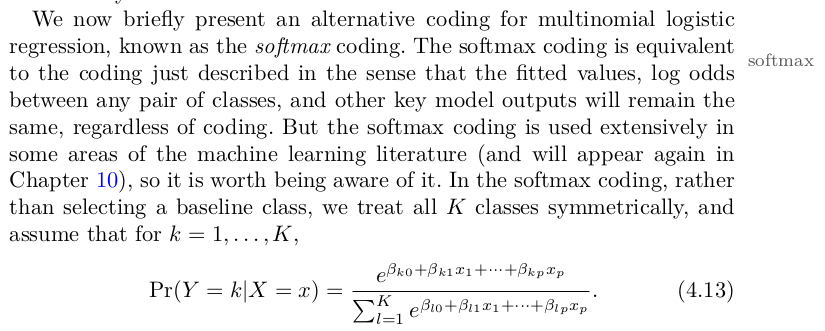

In [155]:
np.random.seed(5)
e = np.array(e)
class1_coeffs = np.random.rand(5)
class2_coeffs = np.random.rand(5)
class1_prob = np.exp(np.sum(class1_coeffs)) / (np.exp(np.sum(class1_coeffs)) + np.exp(np.sum(class2_coeffs)))
class2_prob = np.exp(np.sum(class2_coeffs)) / (np.exp(np.sum(class1_coeffs)) + np.exp(np.sum(class2_coeffs)))
class1_prob

0.5807554346700677

In [156]:
class1_coeffs += 5
class2_coeffs += 5
class1_prob = np.exp(np.sum(class1_coeffs)) / (np.exp(np.sum(class1_coeffs)) + np.exp(np.sum(class2_coeffs)))
class2_prob = np.exp(np.sum(class2_coeffs)) / (np.exp(np.sum(class1_coeffs)) + np.exp(np.sum(class2_coeffs)))
class1_prob

0.5807554346700676

This shows that the softmax function is over-parametrized. However, over-
regularization and SGD typically constrain the solutions so that this parametrized
is not a problem.

3. Show that the negative multinomial log-likelihood (10.14) is equivalent to the negative log of the likelihood expression (4.5) when there are M = 2 classes.

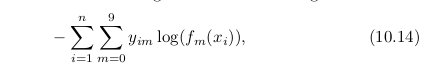
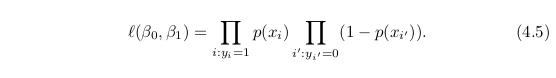

Finding 10.14

Negative Log-Likelihood for Binary Classification.
$L_{\log}(y, p) = -(y \log (p) + (1 - y) \log (1 - p))$

In [229]:
np.random.seed(0)
x = np.random.rand(100)
y = np.zeros(100)
y[50:] = 1

In [239]:
import statsmodels.api as sm
model = sm.GLM(y, sm.add_constant(x), family=sm.families.Binomial()).fit()
p = model.predict(sm.add_constant(x))

# Negative log of the likelihood expression
-np.sum(y * np.log(p) + (1 - y) * np.log(1 - p))

66.7183122339843

In [244]:
# Negative multinomial log-likelihood
-np.sum(y * np.log(p) + y * np.log(p))

66.89718643148652

4. Consider a CNN that takes in 32 x 32 greyscale images and has a single convolution layer with three 5 x 5 convolution filters (without boundary padding).

   (a) Draw a sketch of the input and first hidden layer similar to Figure 10.8.

   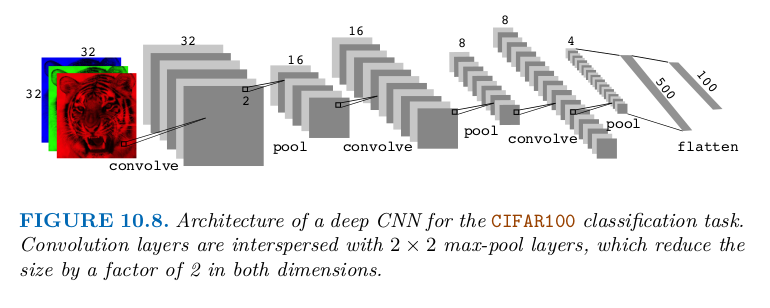

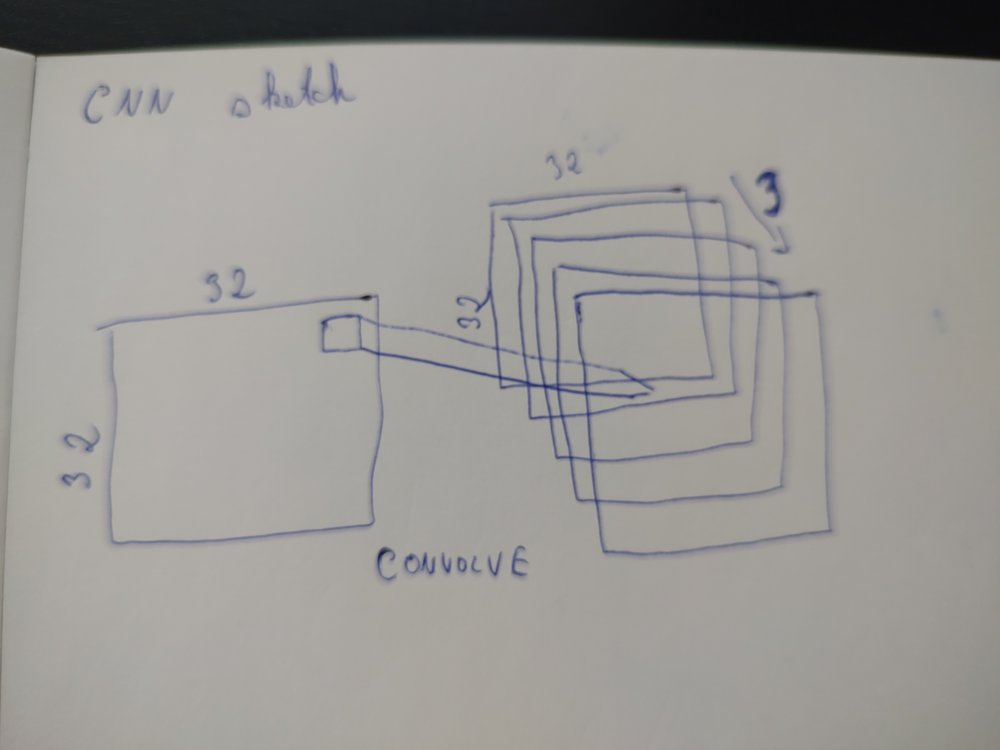

28 instead of 32 in the first hidden layer.

(b) How many parameters are in this model?

Parameters = 3 * 5 * 5 + 3

(c) Explain how this model can be though of as an ordinary feed-forward neural network with the individual pixels as inputs, and with constraints on the weights in the hidden units. What are the constraints?

https://brainly.com/question/40399609

(d) If there were no constraints, then how many weights whould there be in the ordinary feed-dorward neural network in (c)?

In [3]:
n_pixels_input = 32 * 32
n_pixels_hidden1 = 28 * 28
n_weights = n_pixels_input * n_pixels_hidden1
n_weights

802816

5. In table 10.2 on page 426, we see that the ordering of the three methods with respect to mean absolute error is different from the ordering with respect to test set $R^2$. How can this be?

https://stats.stackexchange.com/questions/198483/regression-models-with-comparable-mae-but-differing-r%C2%B2

The lasso model makes smaller mistakes but has an occasional terrible prediction, which lowers the R squared a lot since the R squared uses MSE, which is basically the residuals squared.

## Applied

6. Consider the simple function $R(\beta) = sin(\beta) + \beta/10$.

   (a) Draw a graph of this function ofer the range $\beta \in [-6, 6]$.

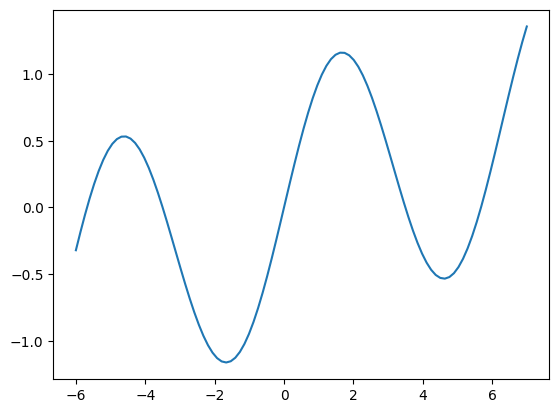

In [46]:
def func(beta):
    return np.sin(beta) + beta/10

x = np.linspace(-6, 7, 100)
y = func(x)

fig = plt.figure(); ax = fig.add_subplot()
ax.plot(x, y)

(b) What is the derivative of this function?

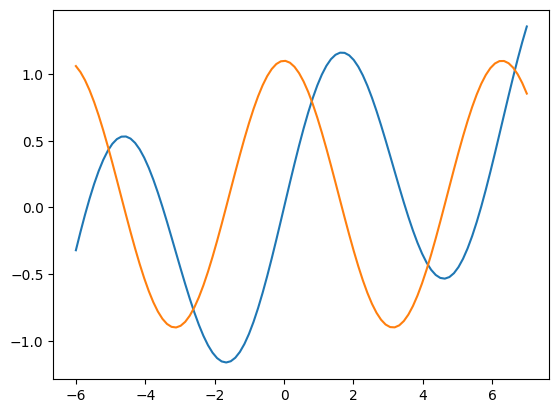

In [47]:
def dx_func(beta):
    return np.cos(beta) + 1/10

x_dx = np.linspace(-6, 7, 100)
y_dx = dx_func(x)

fig = plt.figure(); ax = fig.add_subplot()
ax.plot(x, y)
ax.plot(x_dx, y_dx)

(c) Given $\beta^0 = 2.3$, run gradient descent to find a local minimum of $R(\beta)$ using a learning rate of $p = 0.1$. Show each of $\beta^0, \beta^1, ...$ in your plot, as well as the final answer.

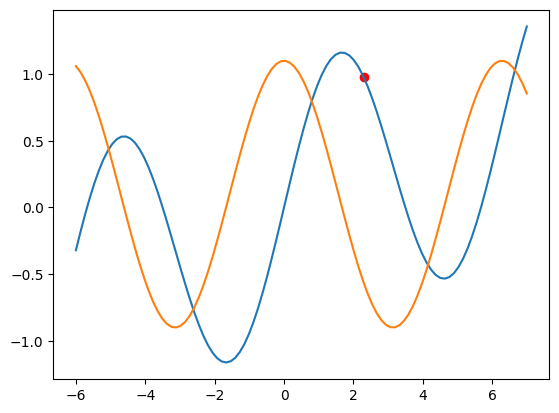

In [48]:
first = func(2.3)
current_pos = (2.3, first)
fig = plt.figure(); ax = fig.add_subplot()
ax.plot(x, y)
ax.plot(x_dx, y_dx)
ax.scatter(current_pos[0], current_pos[1], color='red')

In [82]:
x_values = []
y_values = []
current_pos = (2.3, first)
learning_rate = 0.1
for _ in range(60):
    new_x = current_pos[0] - learning_rate * dx_func(current_pos[0])
    x_values.append(new_x)
    new_y = func(new_x)
    y_values.append(new_y)
    current_pos = new_x, new_y

Text(0, 0.5, '$R(\\beta^0)$')

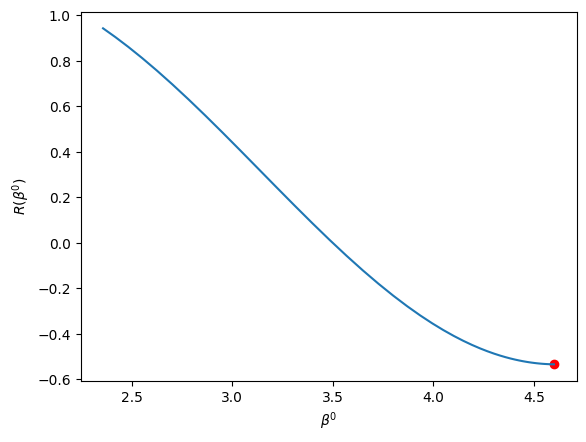

In [83]:
plt.plot(x_values, y_values)
plt.scatter(current_pos[0], current_pos[1], color='red')
plt.xlabel(r'$\beta^0$')
plt.ylabel(r'$R(\beta^0)$')

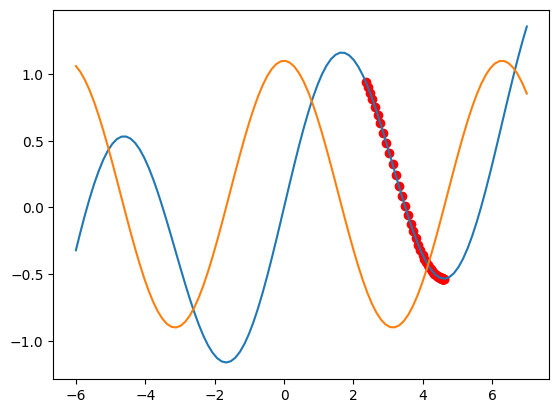

In [85]:
plt.plot(x, y)
plt.plot(x_dx, y_dx)
plt.scatter(x_values, y_values, color='red')

(d) Repeat with $\beta^0 = 1.4$. 

In [86]:
x_values = []
y_values = []
current_pos = (1.4, first)
learning_rate = 0.1
for _ in range(60):
    new_x = current_pos[0] - learning_rate * dx_func(current_pos[0])
    x_values.append(new_x)
    new_y = func(new_x)
    y_values.append(new_y)
    current_pos = new_x, new_y

Text(0, 0.5, '$R(\\beta^0)$')

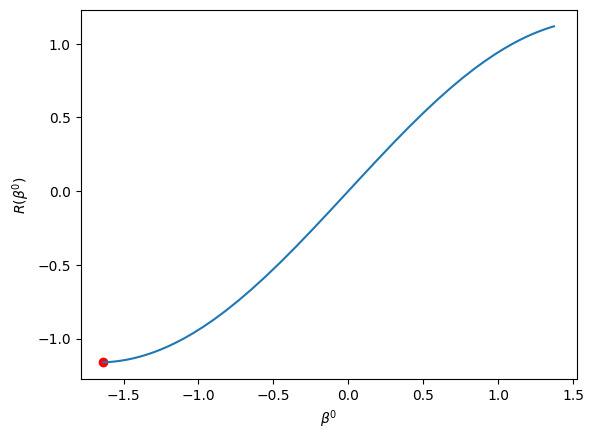

In [87]:
plt.plot(x_values, y_values)
plt.scatter(current_pos[0], current_pos[1], color='red')
plt.xlabel(r'$\beta^0$')
plt.ylabel(r'$R(\beta^0)$')

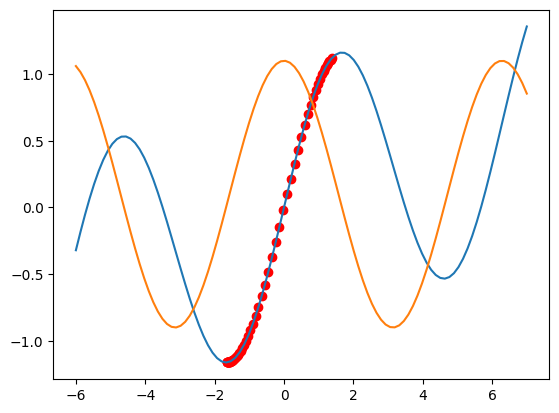

In [88]:
plt.plot(x, y)
plt.plot(x_dx, y_dx)
plt.scatter(x_values, y_values, color='red')

7. Fit a neural network to the Default data. Use a single hidden layer with 10 units, and droupout regularization. Have a look at Labs 10.9.1 - 10.9.2 for guidance. Compare the classification performance of your model with that of linear logistic regression.

In [50]:
Default = load_data('Default')
y = Default['default'].astype('category').cat.codes
X = Default.drop(columns='default')
X['student'] = X['student'].astype('category').cat.codes

X_train, X_test, Y_train, Y_test = train_test_split(X.to_numpy(), y.to_numpy()[:, None], test_size=0.2, random_state=0)

In [51]:
class DefaultModel(nn.Module):

    def __init__(self, input_size):
        super(DefaultModel, self).__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Sequential(
            nn.Linear(input_size, 10),
            nn.ReLU(),
            nn.Dropout(0.2))
        self._forward = nn.Sequential(
            self.layer1,
            nn.Linear(10, 1),
            nn.Sigmoid())

    def forward(self, x):
        return self._forward(x)

In [52]:
default_model = DefaultModel(X.shape[1])

In [53]:
summary(default_model,
        input_size=X_train.shape)

Layer (type:depth-idx)                   Output Shape              Param #
DefaultModel                             [8000, 1]                 --
├─Sequential: 1-1                        [8000, 1]                 --
│    └─Sequential: 2-1                   [8000, 10]                --
│    │    └─Linear: 3-1                  [8000, 10]                40
│    │    └─ReLU: 3-2                    [8000, 10]                --
│    │    └─Dropout: 3-3                 [8000, 10]                --
│    └─Linear: 2-2                       [8000, 1]                 11
│    └─Sigmoid: 2-3                      [8000, 1]                 --
Total params: 51
Trainable params: 51
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.41
Input size (MB): 0.10
Forward/backward pass size (MB): 0.70
Params size (MB): 0.00
Estimated Total Size (MB): 0.80

In [54]:
X_train_t = torch.tensor(X_train.astype(np.float32))
Y_train_t = torch.tensor(Y_train.astype(np.float32))
default_train = TensorDataset(X_train_t, Y_train_t)

In [55]:
X_test_t = torch.tensor(X_test.astype(np.float32))
Y_test_t = torch.tensor(Y_test.astype(np.float32))
default_test = TensorDataset(X_test_t, Y_test_t)

In [56]:
batch_size = 128
train_dataloader = DataLoader(dataset=default_train,
                              batch_size=batch_size,
                              shuffle=True)

test_dataloader = DataLoader(dataset=default_test,
                              batch_size=batch_size,
                              shuffle=False)

In [57]:
learning_rate = 0.1
loss_fn = nn.BCELoss()
optimizer = torch.optim.SGD(default_model.parameters(), lr=learning_rate)

In [70]:
num_epochs = 64
loss_values = []

# Move model to GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
default_model.to(device)

for epoch in range(num_epochs):
    for X, y in tqdm(train_dataloader, desc='Training loop'):
        # # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        X, y = X.to(device), y.to(device)
        pred = default_model(X)
        loss = loss_fn(pred, y)
        loss_values.append(loss.item())
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs} - Train loss: {loss_values[-1]}')
print("Training Complete")

Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 1/64 - Train loss: 3.1294267177581787


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 2/64 - Train loss: 1.6009358167648315


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 3/64 - Train loss: 4.693839073181152


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 4/64 - Train loss: 7.816632270812988


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 5/64 - Train loss: 4.72449254989624


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 6/64 - Train loss: 1.5664634704589844


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 7/64 - Train loss: 1.5663893222808838


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 8/64 - Train loss: 1.5625


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 9/64 - Train loss: 3.1343154907226562


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 10/64 - Train loss: 1.5679924488067627


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 11/64 - Train loss: 0.0017917673103511333


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 12/64 - Train loss: 0.038517918437719345


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 13/64 - Train loss: 1.5642321109771729


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 14/64 - Train loss: 1.5658973455429077


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 15/64 - Train loss: 1.5625


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 16/64 - Train loss: 3.128293514251709


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 17/64 - Train loss: 4.693999290466309


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 18/64 - Train loss: 4.695497989654541


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 19/64 - Train loss: 0.0047241090796887875


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 20/64 - Train loss: 0.004661290440708399


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 21/64 - Train loss: 3.126525640487671


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 22/64 - Train loss: 3.1309914588928223


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 23/64 - Train loss: 4.6904473304748535


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 24/64 - Train loss: 3.1279115676879883


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 25/64 - Train loss: 4.688939094543457


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 26/64 - Train loss: 3.1335208415985107


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 27/64 - Train loss: 3.1292006969451904


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 28/64 - Train loss: 10.941640853881836


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 29/64 - Train loss: 1.563862919807434


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 30/64 - Train loss: 4.6915507316589355


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 31/64 - Train loss: 3.1263370513916016


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 32/64 - Train loss: 3.1263203620910645


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 33/64 - Train loss: 3.1263046264648438


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 34/64 - Train loss: 1.5663620233535767


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 35/64 - Train loss: 1.5650453567504883


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 36/64 - Train loss: 1.5675166845321655


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 37/64 - Train loss: 3.127480983734131


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 38/64 - Train loss: 3.1666152477264404


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 39/64 - Train loss: 4.691146373748779


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 40/64 - Train loss: 4.689914226531982


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 41/64 - Train loss: 1.5625


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 42/64 - Train loss: 1.5625


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 43/64 - Train loss: 4.729747772216797


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 44/64 - Train loss: 6.253481864929199


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 45/64 - Train loss: 4.6875


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 46/64 - Train loss: 0.0011374654714018106


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 47/64 - Train loss: 3.128390073776245


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 48/64 - Train loss: 4.693092346191406


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 49/64 - Train loss: 4.730493545532227


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 50/64 - Train loss: 0.0032934490591287613


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 51/64 - Train loss: 0.004341837950050831


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 52/64 - Train loss: 3.130425214767456


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 53/64 - Train loss: 6.252144813537598


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 54/64 - Train loss: 1.565685749053955


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 55/64 - Train loss: 3.126054286956787


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 56/64 - Train loss: 1.5635498762130737


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 57/64 - Train loss: 4.688539981842041


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 58/64 - Train loss: 3.127061128616333


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 59/64 - Train loss: 6.254077911376953


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 60/64 - Train loss: 1.5645160675048828


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 61/64 - Train loss: 1.564509391784668


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 62/64 - Train loss: 3.127988815307617


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 63/64 - Train loss: 0.003963678143918514


Training loop:   0%|          | 0/63 [00:00<?, ?it/s]

Epoch 64/64 - Train loss: 0.0009825543966144323
Training Complete


In [73]:
# compute accuracy (no_grad is optional)
X_test_t, Y_test_t = X_test_t.to(device), Y_test_t.to(device)
y_pred = default_model(X_test_t)
accuracy = (y_pred.round() == Y_test_t).float().mean()
print(f"Accuracy {accuracy}")

Accuracy 0.9630000591278076


#### Logistic Regression

In [24]:
logistic_model = LogisticRegression()
logistic_model.fit(X_train, Y_train.flatten())
y_pred = logistic_model.predict(X_test)
accuracy = (y_pred.round() == Y_test).mean()
accuracy

0.950962

8. From your collection of personal photographs, pick 10 images of animals (such as dogs, cats, birds, farm animals, etc.). If the subject does not occupy a reasonable part of the image, then crop the image. Now use a petrained image classification CNN as in lab 10.9.4 to predict the class of your images, and report the probabilities for the top five predicted classes for each image.

In [2]:
folder = r'data/Deep_learning_exercise_8_photos/'

In [3]:
imgfiles = [img for img in glob(folder+'*', recursive=True)]
imgs_tr = []
for i, img in enumerate(imgfiles):
    img = Image.open(img)
    # Get mean and std
    transform = Compose([ToTensor()])
    img_tensor = transform(img)
    mean, std = img_tensor.mean([1, 2]), img_tensor.std([1, 2])
    # Resize, crop and normalize
    transform_norm = Compose([
        ToTensor(),
        Resize((232, 232)),
        CenterCrop(224),
        Normalize(mean, std)
    ])
    img_tr = transform_norm(img)
    imgs_tr.append(img_tr)
imgs = torch.stack(imgs_tr)

/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [4]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)
summary(resnet_model,
        input_data=imgs,
        col_names=['input_size',
                   'output_size',
                   'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [12, 3, 224, 224]         [12, 1000]                --
├─Conv2d: 1-1                            [12, 3, 224, 224]         [12, 64, 112, 112]        9,408
├─BatchNorm2d: 1-2                       [12, 64, 112, 112]        [12, 64, 112, 112]        128
├─ReLU: 1-3                              [12, 64, 112, 112]        [12, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [12, 64, 112, 112]        [12, 64, 56, 56]          --
├─Sequential: 1-5                        [12, 64, 56, 56]          [12, 256, 56, 56]         --
│    └─Bottleneck: 2-1                   [12, 64, 56, 56]          [12, 256, 56, 56]         --
│    │    └─Conv2d: 3-1                  [12, 64, 56, 56]          [12, 64, 56, 56]          4,096
│    │    └─BatchNorm2d: 3-2             [12, 64, 56, 56]          [12, 64, 56, 56]          128
│    │    └─ReLU: 3-3      

In [5]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [6]:
img_preds = resnet_model(imgs)

In [7]:
img_probs = np.exp(np.asarray(img_preds.detach()))
img_probs /= img_probs.sum(1)[:, None]

In [8]:
labs = json.load(open('imagenet_index/imagenet_class_index.json'))
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in
                           labs.items()],
                           columns=['idx', 'label'])
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()

In [10]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:5]
    print(f'Image: {imgfile}')
    print(img_df.reset_index().drop(columns=['idx']))

Image: data/Deep_learning_exercise_8_photos/2.jpg
          label      prob
0  king_penguin  0.330411
1      sea_lion  0.127552
2         otter  0.056118
3  black_grouse  0.026250
4        beaver  0.019340
Image: data/Deep_learning_exercise_8_photos/8.jpg
          label      prob
0         tabby  0.239517
1  Egyptian_cat  0.122861
2     tiger_cat  0.083444
3          lynx  0.005892
4        laptop  0.003321
Image: data/Deep_learning_exercise_8_photos/7.jpg
           label      prob
0          tabby  0.171946
1      tiger_cat  0.057058
2   Egyptian_cat  0.039934
3           lynx  0.036710
4  digital_clock  0.027905
Image: data/Deep_learning_exercise_8_photos/6.jpg
          label      prob
0         tabby  0.249045
1     tiger_cat  0.075938
2   Persian_cat  0.045165
3          lynx  0.021955
4  Egyptian_cat  0.011185
Image: data/Deep_learning_exercise_8_photos/5.jpg
          label      prob
0         tabby  0.063435
1  Egyptian_cat  0.045184
2     tiger_cat  0.040550
3   Persian_cat 

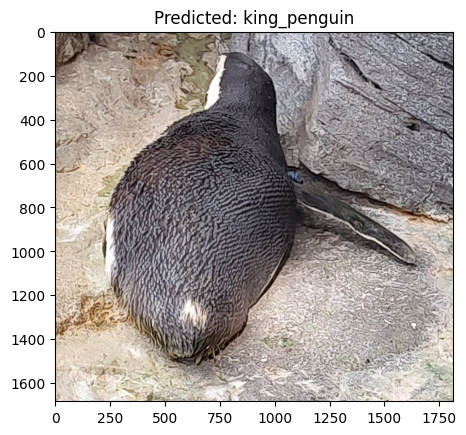

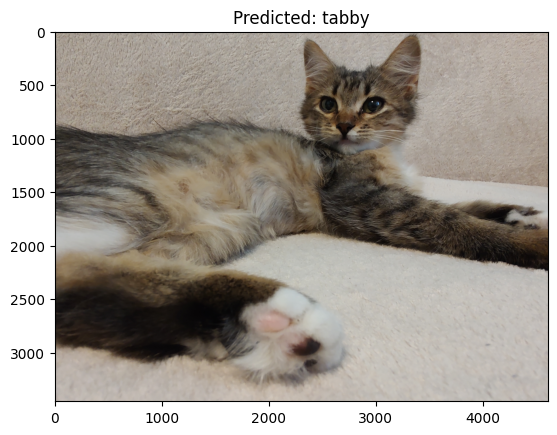

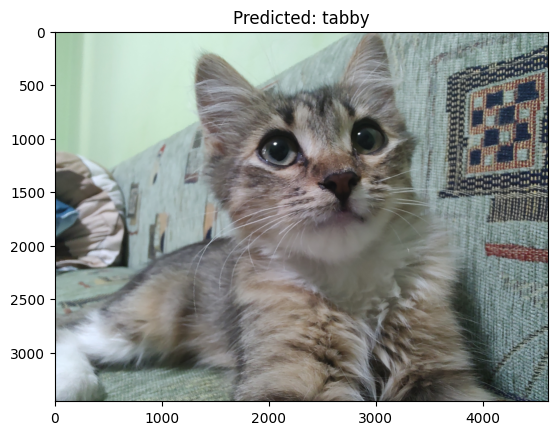

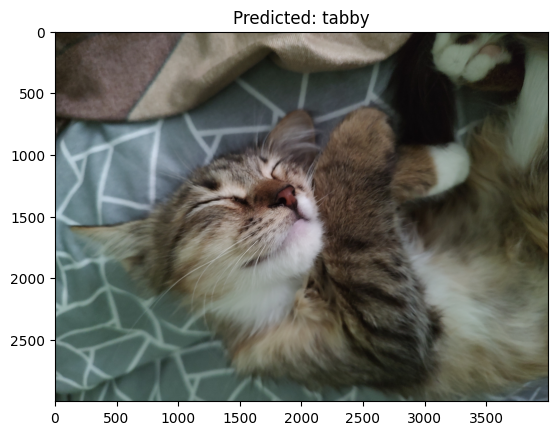

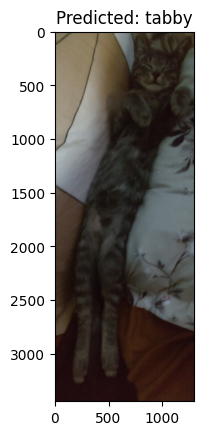

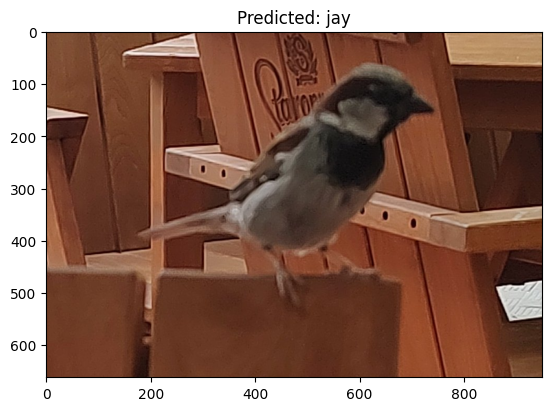

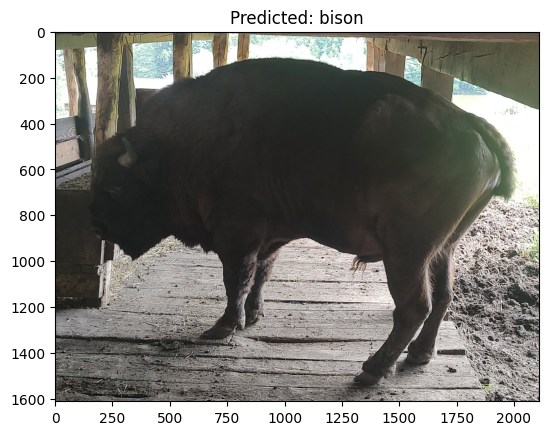

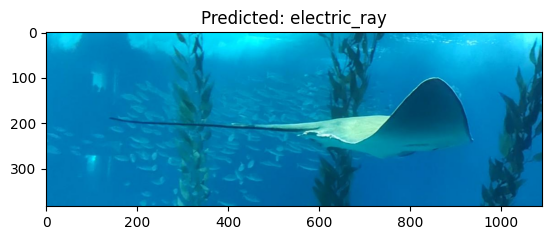

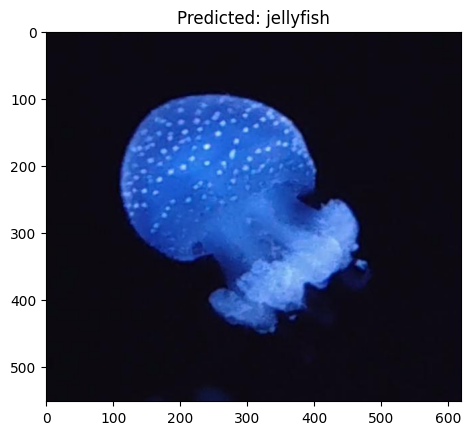

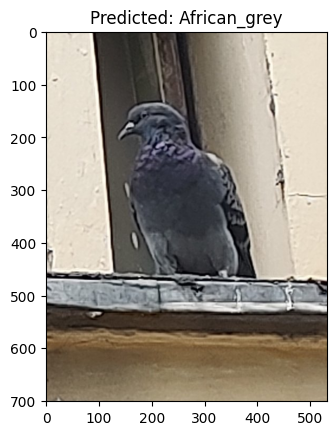

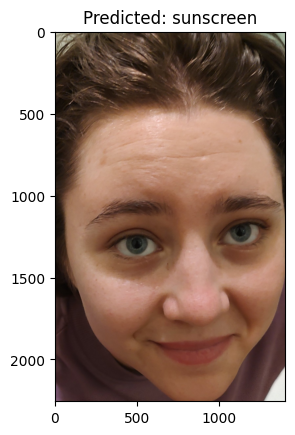

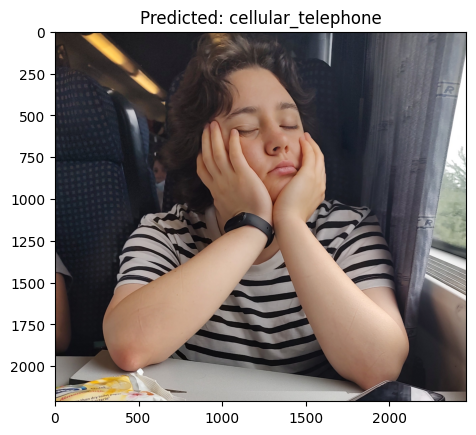

In [11]:
for i, (imgfile, img) in enumerate(zip(imgfiles, imgs)):
    imgfile = Image.open(imgfile)
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:1]
    fig, ax = plt.subplots()
    ax.imshow(imgfile)
    ax.set_title(f'Predicted: {img_df["label"].values[0]}')

9. Fit a lag-5 autoregressive model to the NYSE data, as described in the text and Lab 10.9.6. Refit the model with a 12-level factor representing the month. Does this factor improve the performance of the model?

In [363]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
                    with_mean=True,
                    with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)

In [364]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), '{0}_{1}'.format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [365]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [366]:
X_day = pd.merge(X,
                 pd.get_dummies(NYSE['day_of_week']),
                 on='date')

In [367]:
ordered_cols = []
for lag in range (5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col , lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [368]:
X_rnn = X.to_numpy().reshape((-1, 5, 3))

In [369]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
                    np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

In [370]:
day_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=min(4, max_num_workers),
                          validation=day_test,
                          batch_size=64)

In [371]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),
                                      nn.Linear(20, 32),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(32, 1))
    def forward(self, x):
        return torch.flatten(self._forward(x

In [324]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),
                       lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                    optimizer=nl_optimizer,
                                    metrics={'r2':R2Score()})

In [325]:
nl_trainer = Trainer(deterministic=True,
                     max_epochs=20,
                     callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type             | Params
-------------------------------------------
0 | model | NonLinearARModel | 705   
1 | loss  | MSELoss          | 0     
-------------------------------------------
705       Trainable params
0         Non-trainable params
705       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5636802315711975
         test_r2            0.4650399684906006
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5636802315711975, 'test_r2': 0.4650399684906006}]

### Using a model with a month as a factor instead

In [302]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
                    with_mean=True,
                    with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)

In [303]:
for lag in range(1, 13):
    for col in cols:
        days_lag = lag * 30
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[days_lag:] = X[col].values[:-days_lag]
        X.insert(len(X.columns), '{0}_{1}'.format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [304]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_6',
       'log_volume_6', 'log_volatility_6', 'DJ_return_7', 'log_volume_7',
       'log_volatility_7', 'DJ_return_8', 'log_volume_8', 'log_volatility_8',
       'DJ_return_9', 'log_volume_9', 'log_volatility_9', 'DJ_return_10',
       'log_volume_10', 'log_volatility_10', 'DJ_return_11', 'log_volume_11',
       'log_volatility_11', 'DJ_return_12', 'log_volume_12',
       'log_volatility_12'],
      dtype='object')

In [305]:
ordered_cols = []
for lag in range (12, 0, -1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col , lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_12', 'log_volume_12', 'log_volatility_12', 'DJ_return_11',
       'log_volume_11', 'log_volatility_11', 'DJ_return_10', 'log_volume_10',
       'log_volatility_10', 'DJ_return_9', 'log_volume_9', 'log_volatility_9',
       'DJ_return_8', 'log_volume_8', 'log_volatility_8', 'DJ_return_7',
       'log_volume_7', 'log_volatility_7', 'DJ_return_6', 'log_volume_6',
       'log_volatility_6', 'DJ_return_5', 'log_volume_5', 'log_volatility_5',
       'DJ_return_4', 'log_volume_4', 'log_volatility_4', 'DJ_return_3',
       'log_volume_3', 'log_volatility_3', 'DJ_return_2', 'log_volume_2',
       'log_volatility_2', 'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [306]:
X_rnn = X.to_numpy().reshape((-1, 12, 3))

In [307]:
NYSE['month_of_year'] = pd.to_datetime(NYSE.index).month

In [308]:
X_month = pd.merge(X,
                 pd.get_dummies(NYSE['month_of_year']),
                 on='date')

In [309]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
                    np.asarray(X_month[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

In [310]:
day_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=min(4, max_num_workers),
                          validation=day_test,
                          batch_size=64)

In [311]:
class NonLinearARModel(nn.Module):
    def __init__(self, input_size):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(),
                                      nn.Linear(input_size, 32),
                                      nn.ReLU(),
                                      nn.Dropout(0.5),
                                      nn.Linear(32, 1))
    def forward(self, x):
        return torch.flatten(self._forward(x))

In [312]:
nl_model = NonLinearARModel(X_month.shape[1])
nl_optimizer = RMSprop(nl_model.parameters(),
                       lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                    optimizer=nl_optimizer,
                                    metrics={'r2':R2Score()})

In [313]:
nl_trainer = Trainer(deterministic=True,
                     max_epochs=100,
                     callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type             | Params
-------------------------------------------
0 | model | NonLinearARModel | 1.6 K 
1 | loss  | MSELoss          | 0     
-------------------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0946577787399292
         test_r2           -0.03888356685638428
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 1.0946577787399292, 'test_r2': -0.03888356685638428}]

The model is way worse.

10. In section 10.9.6, we showed how to fit a linear AR model to the NYSE data using the LinearRegression() function. However, we also mentioned that we can 'flatten' the short sequences produced for  the RNN model in order to fit a linear AR model. Use this latter approach to fit a linear AR model to the NYSE data. Compare the test $R^2$ of this linear AR model to that of the linear AR model that we fit in the lab. What are  the advantages/disadvantages of each approach?

In [394]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(StandardScaler(
                    with_mean=True,
                    with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)

In [395]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), '{0}_{1}'.format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [396]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4', 'log_volatility_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5'],
      dtype='object')

In [397]:
X_day = pd.merge(X,
                 pd.get_dummies(NYSE['day_of_week']),
                 on='date')

In [398]:
ordered_cols = []
for lag in range (5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col , lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'DJ_return_4',
       'log_volume_4', 'log_volatility_4', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_2', 'log_volume_2', 'log_volatility_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1'],
      dtype='object')

In [399]:
X_rnn = X.to_numpy().reshape((-1, 5, 3))

In [400]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
                    np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32)[:, None])
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

In [402]:
day_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=min(4, max_num_workers),
                          validation=day_test,
                          batch_size=64)

In [403]:
class NYSEARModel(nn.Module):
    def __init__(self, input_size):
        super(NYSEARModel, self).__init__()
        self.flatten = nn.Flatten()
        self._forward = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 1))
    def forward(self, x):
        return self._forward(x)

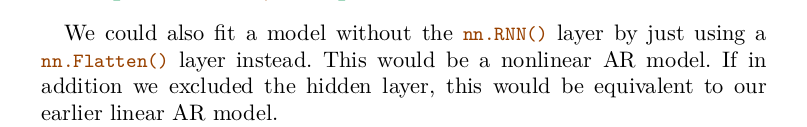

In [404]:
nl_model = NYSEARModel(X_day.shape[1])
nl_optimizer = RMSprop(nl_model.parameters(),
                       lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                    optimizer=nl_optimizer,
                                    metrics={'r2':R2Score()})

In [405]:
nl_trainer = Trainer(deterministic=True,
                     max_epochs=20,
                     callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type        | Params
--------------------------------------
0 | model | NYSEARModel | 21    
1 | loss  | MSELoss     | 0     
--------------------------------------
21        Trainable params
0         Non-trainable params
21        Total params
0.000     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5814933180809021
         test_r2            0.44813448190689087
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5814933180809021, 'test_r2': 0.44813448190689087}]

The R squared value of this model is a little bit lower then that of the LinearRegression method, but they are mostly the same.

11. Repeat the previous exercise, but now fit a nonlinear AR model by 'flattening' the short sequences produced for the RNN model.

In [413]:
class NYSENLModel(nn.Module):
    def __init__(self, input_size):
        super(NYSENLModel, self).__init__()
        self.flatten = nn.Flatten()
        self._forward = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_size, 20),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(20, 1))
    def forward(self, x):
        return self._forward(x)

In [414]:
nl_model = NYSENLModel(X_day.shape[1])
nl_optimizer = RMSprop(nl_model.parameters(),
                       lr=0.001)
nl_module = SimpleModule.regression(nl_model,
                                    optimizer=nl_optimizer,
                                    metrics={'r2':R2Score()})

In [415]:
nl_trainer = Trainer(deterministic=True,
                     max_epochs=20,
                     callbacks=[ErrorTracker()])
nl_trainer.fit(nl_module, datamodule=day_dm)
nl_trainer.test(nl_module, datamodule=day_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type        | Params
--------------------------------------
0 | model | NYSENLModel | 441   
1 | loss  | MSELoss     | 0     
--------------------------------------
441       Trainable params
0         Non-trainable params
441       Total params
0.002     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.56037837266922
         test_r2            0.4681735634803772
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.56037837266922, 'test_r2': 0.4681735634803772}]

12. Consider the RNN fit to the NYSE data in section 10.9.6. Modify the code to allow inclusion of the variable day_of_week, and fit the RNN. Compute the test $R^2$.

In [453]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3,
                          12,
                          batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:, -1]))
        return torch.flatten(val)
nyse_model = NYSEModel()

In [454]:
NYSE = load_data('NYSE')
cols = ['DJ_return', 'log_volume', 'log_volatility']
map_dow = {'mon': 0,
           'tues': 1,
           'wed': 2,
           'thur': 3,
           'fri': 4}
NYSE = NYSE.replace({'day_of_week': map_dow})
X = pd.DataFrame(StandardScaler(
                    with_mean=True,
                    with_std=True).fit_transform(NYSE[cols]),
                 columns=NYSE[cols].columns,
                 index=NYSE.index)
X['day_of_week'] = NYSE['day_of_week']
cols = ['DJ_return', 'log_volume', 'log_volatility', 'day_of_week']

In [455]:
for lag in range(1, 6):
    for col in cols:
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), '{0}_{1}'.format(col, lag), newcol)
X.insert(len(X.columns), 'train', NYSE['train'])
X = X.dropna()

In [456]:
Y, train = X['log_volume'], X['train']
X = X.drop(columns=['train'] + cols)
X.columns

Index(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'day_of_week_1',
       'DJ_return_2', 'log_volume_2', 'log_volatility_2', 'day_of_week_2',
       'DJ_return_3', 'log_volume_3', 'log_volatility_3', 'day_of_week_3',
       'DJ_return_4', 'log_volume_4', 'log_volatility_4', 'day_of_week_4',
       'DJ_return_5', 'log_volume_5', 'log_volatility_5', 'day_of_week_5'],
      dtype='object')

In [457]:
X_day = pd.merge(X,
                 pd.get_dummies(NYSE['day_of_week']),
                 on='date')

In [458]:
ordered_cols = []
for lag in range (5,0,-1):
    for col in cols:
        ordered_cols.append('{0}_{1}'.format(col , lag))
X = X.reindex(columns=ordered_cols)
X.columns

Index(['DJ_return_5', 'log_volume_5', 'log_volatility_5', 'day_of_week_5',
       'DJ_return_4', 'log_volume_4', 'log_volatility_4', 'day_of_week_4',
       'DJ_return_3', 'log_volume_3', 'log_volatility_3', 'day_of_week_3',
       'DJ_return_2', 'log_volume_2', 'log_volatility_2', 'day_of_week_2',
       'DJ_return_1', 'log_volume_1', 'log_volatility_1', 'day_of_week_1'],
      dtype='object')

In [460]:
X_rnn = X.to_numpy().reshape((-1, 5, 4))

In [461]:
datasets = []
for mask in [train, ~train]:
    X_day_t = torch.tensor(
                    np.asarray(X_day[mask]).astype(np.float32))
    Y_t = torch.tensor(np.asarray(Y[mask]).astype(np.float32)[:, None])
    datasets.append(TensorDataset(X_day_t, Y_t))
day_train, day_test = datasets

In [462]:
day_dm = SimpleDataModule(day_train,
                          day_test,
                          num_workers=min(4, max_num_workers),
                          validation=day_test,
                          batch_size=64)

In [463]:
for idx, (x, y) in enumerate(nyse_dm.train_dataloader()):
    out = nyse_model(x)
    print(y.size(), out.size())
    if idx >= 2:
        break

torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])
torch.Size([64]) torch.Size([64])


In [464]:
nyse_optimizer = RMSprop(nyse_model.parameters(),
                         lr=0.001)
nyse_module = SimpleModule.regression(nyse_model,
                                      optimizer=nyse_optimizer,
                                      metrics={'r2':R2Score()})

In [465]:
nyse_trainer = Trainer(deterministic=True,
                       max_epochs=200,
                       callbacks=[ErrorTracker()])
nyse_trainer.fit(nyse_module,
                 datamodule=nyse_dm)
nyse_trainer.test(nyse_module,
                  datamodule=nyse_dm)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/alex/mambaforge/envs/stats/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:175: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type      | Params
------------------------------------
0 | model | NYSEModel | 217   
1 | loss  | MSELoss   | 0     
------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6190983653068542
         test_r2            0.41244542598724365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.6190983653068542, 'test_r2': 0.41244542598724365}]